In [1]:
## McKinsey Hackathon - submission by ShayanRay
## Model used: MLP

In [2]:
# library imports
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import utils
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score

In [3]:
# Load Train and Test CSV

headerNames = ["ID","Gender","DOB","Lead_Creation_Date","City_Code","City_Category","Employer_Code","Employer_Category1",
               "Employer_Category2","Monthly_Income","Customer_Existing_Primary_Bank_Code","Primary_Bank_Type","Contacted",
               "Source","Source_Category","Existing_EMI","Loan_Amount","Loan_Period","Interest_Rate","EMI","Var1","Approved"]
prefix = "/data/McKinsey/"

# it is mentioned not to use ID for prediction 
# hence setting index_col = 0 takes care of removing ID field from dataset in both train and test dataframes.
traindf = pd.read_csv(prefix + "train.csv", header=None, delim_whitespace=False,  names=headerNames, index_col=0,) 
testdf = pd.read_csv(prefix + "test.csv", header=None, delim_whitespace=False,  names=headerNames, index_col=0,)
testdf = testdf.drop('Approved', axis=1)

#sample data for a quick run
#traindf = traindf.sample(frac=0.25, replace=True)

traindf.shape

(69713, 21)

In [4]:
#top 10 records displayed
traindf.head(10)

,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
ID,,,,,,,,,,,,,,,,,,,,,
APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,B001,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0
APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,B002,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,B003,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0
APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,B003,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0
APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,B001,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0
APPI90914237819,Female,23/12/88,01/07/16,C10402,C,COM0007740,A,4.0,7000.0,B014,...,N,S133,B,0.0,NaN,NaN,NaN,NaN,0,0
APPK80327232033,Male,28/03/73,02/07/16,C10022,B,COM0030526,B,4.0,7500.0,B003,...,Y,S122,C,0.0,130000.0,5.0,14.85,3082.0,10,0
APPL20820172146,Female,12/11/90,03/07/16,C10003,A,COM0016738,A,4.0,3000.0,B006,...,Y,S133,B,0.0,30000.0,3.0,18.25,1088.0,0,0
APPM30977401211,Male,03/03/77,02/07/16,C10003,A,COM0010626,A,4.0,2500.0,B017,...,Y,S133,B,0.0,66000.0,5.0,20.00,1749.0,7,0


In [5]:
# Set of Unique Values for approved - it is a binary classification problem
print(traindf['Approved'].unique())
traindf.columns

[0 1]


Index(['Gender', 'DOB', 'Lead_Creation_Date', 'City_Code', 'City_Category',
       'Employer_Code', 'Employer_Category1', 'Employer_Category2',
       'Monthly_Income', 'Customer_Existing_Primary_Bank_Code',
       'Primary_Bank_Type', 'Contacted', 'Source', 'Source_Category',
       'Existing_EMI', 'Loan_Amount', 'Loan_Period', 'Interest_Rate', 'EMI',
       'Var1', 'Approved'],
      dtype='object')

In [6]:
# Train Data Stats
traindf.describe()


,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
count,65415.000000,6.971300e+04,69662.000000,42004.000000,42004.000000,22276.000000,22276.000000,69713.000000,69713.000000
mean,3.720187,5.622283e+03,360.928751,39429.982859,3.890629,19.213570,1101.466242,3.948446,0.014631
std,0.807374,1.747671e+05,2288.517927,30727.595990,1.167491,5.847136,752.661394,3.819214,0.120073
min,1.000000,0.000000e+00,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,0.000000
25%,4.000000,1.650000e+03,0.000000,20000.000000,3.000000,15.250000,649.000000,0.000000,0.000000
50%,4.000000,2.500000e+03,0.000000,30000.000000,4.000000,18.000000,941.000000,2.000000,0.000000
75%,4.000000,4.000000e+03,350.000000,50000.000000,5.000000,20.000000,1295.000000,7.000000,0.000000
max,4.000000,3.838384e+07,545436.500000,300000.000000,6.000000,37.000000,13556.000000,10.000000,1.000000


In [7]:
# stats of categorical features
traindf.describe(include=['O'])

,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,Contacted,Source,Source_Category
count,69713,69698,69713,68899,68899,65695,65695,60322,60322,69713,69713,69713
unique,2,10759,92,678,3,36617,3,57,2,2,29,7
top,Male,11/01/82,02/09/16,C10001,A,COM0000002,A,B001,P,Y,S122,B
freq,39949,253,1838,10007,49885,457,33336,14197,39619,45275,30941,29812


In [8]:
# for starters, fill every nan value with mean column values across the dataset.
# set to 0 for feature selection
#traindf = traindf.fillna(0.0) 
#testdf = testdf.fillna(0.0) 

#fill NaN values with mean for training
traindf['Employer_Category2'].fillna(traindf['Employer_Category2'].dropna().median(), inplace=True)
traindf['Monthly_Income'].fillna(traindf['Monthly_Income'].dropna().median(), inplace=True)
traindf['Existing_EMI'].fillna(traindf['Existing_EMI'].dropna().median(), inplace=True)
traindf['Loan_Amount'].fillna(traindf['Loan_Amount'].dropna().median(), inplace=True)
traindf['Loan_Period'].fillna(traindf['Loan_Period'].dropna().median(), inplace=True)
traindf['Interest_Rate'].fillna(traindf['Interest_Rate'].dropna().median(), inplace=True)
traindf['EMI'].fillna(traindf['EMI'].dropna().median(), inplace=True)

#fill NaN values with mean for test
testdf['Employer_Category2'].fillna(testdf['Employer_Category2'].dropna().median(), inplace=True)
testdf['Monthly_Income'].fillna(testdf['Monthly_Income'].dropna().median(), inplace=True)
testdf['Existing_EMI'].fillna(testdf['Existing_EMI'].dropna().median(), inplace=True)
testdf['Loan_Amount'].fillna(testdf['Loan_Amount'].dropna().median(), inplace=True)
testdf['Loan_Period'].fillna(testdf['Loan_Period'].dropna().median(), inplace=True)
testdf['Interest_Rate'].fillna(testdf['Interest_Rate'].dropna().median(), inplace=True)
testdf['EMI'].fillna(testdf['EMI'].dropna().median(), inplace=True)

traindf.head(10)

,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
ID,,,,,,,,,,,,,,,,,,,,,
APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,B001,...,N,S122,G,0.0,30000.0,4.0,18.00,941.0,0,0
APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,B002,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0
APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,B003,...,Y,S143,B,0.0,45000.0,4.0,18.00,941.0,0,0
APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,B003,...,Y,S143,B,0.0,92000.0,5.0,18.00,941.0,7,0
APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,B001,...,Y,S134,B,2500.0,50000.0,2.0,18.00,941.0,10,0
APPI90914237819,Female,23/12/88,01/07/16,C10402,C,COM0007740,A,4.0,7000.0,B014,...,N,S133,B,0.0,30000.0,4.0,18.00,941.0,0,0
APPK80327232033,Male,28/03/73,02/07/16,C10022,B,COM0030526,B,4.0,7500.0,B003,...,Y,S122,C,0.0,130000.0,5.0,14.85,3082.0,10,0
APPL20820172146,Female,12/11/90,03/07/16,C10003,A,COM0016738,A,4.0,3000.0,B006,...,Y,S133,B,0.0,30000.0,3.0,18.25,1088.0,0,0
APPM30977401211,Male,03/03/77,02/07/16,C10003,A,COM0010626,A,4.0,2500.0,B017,...,Y,S133,B,0.0,66000.0,5.0,20.00,1749.0,7,0


In [9]:
# Feature Engineering - Convert Categorical Data to Numeric > Gender
# convert Gender to numeric

#Train Data
traindf['Gender_numeric']  = 0.0 # default value
traindf.loc[traindf['Gender'] == 'Male', 'Gender_numeric'] = 1.0
traindf.loc[traindf['Gender'] == 'Female', 'Gender_numeric'] = 2.0
traindf = traindf.drop('Gender', axis=1)

#Test Data
testdf['Gender_numeric']  = 0.0 # default value
testdf.loc[testdf['Gender'] == 'Male', 'Gender_numeric'] = 1.0
testdf.loc[testdf['Gender'] == 'Female', 'Gender_numeric'] = 2.0
testdf = testdf.drop('Gender', axis=1)

In [10]:
# Feature Engineering - Convert Categorical Data to Numeric > City_Code
# convert City_Code to numeric

#Train Data
traindf['City_Code_numeric']  = 0.0 # default value
traindf.loc[traindf['City_Code'] != 0.0, 'City_Code_numeric'] = traindf['City_Code'].str.slice(start=1).astype(float)
traindf['City_Code_numeric'].fillna(traindf['City_Code_numeric'].dropna().median(), inplace=True)
traindf = traindf.drop('City_Code', axis=1)

#Test Data

testdf['City_Code_numeric']  = 0.0 # default value
testdf.loc[testdf['City_Code'] != 0.0, 'City_Code_numeric'] = testdf['City_Code'].str.slice(start=1).astype(float)
testdf['City_Code_numeric'].fillna(testdf['City_Code_numeric'].dropna().median(), inplace=True)
testdf = testdf.drop('City_Code', axis=1)

In [11]:
# Feature Engineering - Convert Categorical Data to Numeric > City_Category
# convert City_Category to numeric
traindf['City_Category'].unique()

#Train Data
traindf['City_Category_numeric']  = 0.0 # default value
traindf.loc[traindf['City_Category'] == 'A', 'City_Category_numeric'] = 1.0
traindf.loc[traindf['City_Category'] == 'B', 'City_Category_numeric'] = 2.0
traindf.loc[traindf['City_Category'] == 'C', 'City_Category_numeric'] = 3.0
traindf['City_Category_numeric'].unique()
traindf = traindf.drop('City_Category', axis=1)

#Test Data
testdf['City_Category_numeric']  = 0.0 # default value
testdf.loc[testdf['City_Category'] == 'A', 'City_Category_numeric'] = 1.0
testdf.loc[testdf['City_Category'] == 'B', 'City_Category_numeric'] = 2.0
testdf.loc[testdf['City_Category'] == 'C', 'City_Category_numeric'] = 3.0
testdf['City_Category_numeric'].unique()
testdf = testdf.drop('City_Category', axis=1)

In [12]:
# Feature Engineering - Convert Categorical Data to Numeric > Employer_Code
# convert Employer_Code to numeric
traindf['Employer_Code'].unique()


#Train Data
traindf['Employer_Code_numeric']  = 0.0 # default value
traindf.loc[traindf['Employer_Code'] != 0.0, 'Employer_Code_numeric'] = traindf['Employer_Code'].str.slice(start=3).astype(float)
traindf['Employer_Code_numeric'].fillna(traindf['Employer_Code_numeric'].dropna().median(), inplace=True)
traindf = traindf.drop('Employer_Code', axis=1)

#Test Data

testdf['Employer_Code_numeric']  = 0.0 # default value
testdf.loc[testdf['Employer_Code'] != 0.0, 'Employer_Code_numeric'] = testdf['Employer_Code'].str.slice(start=3).astype(float)
testdf['Employer_Code_numeric'].fillna(testdf['Employer_Code_numeric'].dropna().median(), inplace=True)
testdf = testdf.drop('Employer_Code', axis=1)

In [13]:
# Feature Engineering - Convert Categorical Data to Numeric > Employer_Category1
# convert Employer_Category1 to numeric
traindf['Employer_Category1'].unique()


#Train Data
traindf['Employer_Category1_numeric']  = 0.0 # default value
traindf.loc[traindf['Employer_Category1'] == 'A', 'Employer_Category1_numeric'] = 1.0
traindf.loc[traindf['Employer_Category1'] == 'B', 'Employer_Category1_numeric'] = 2.0
traindf.loc[traindf['Employer_Category1'] == 'C', 'Employer_Category1_numeric'] = 3.0
traindf = traindf.drop('Employer_Category1', axis=1)

#Test Data
testdf['Employer_Category1_numeric']  = 0.0 # default value
testdf.loc[testdf['Employer_Category1'] == 'A', 'Employer_Category1_numeric'] = 1.0
testdf.loc[testdf['Employer_Category1'] == 'B', 'Employer_Category1_numeric'] = 2.0
testdf.loc[testdf['Employer_Category1'] == 'C', 'Employer_Category1_numeric'] = 3.0
testdf = testdf.drop('Employer_Category1', axis=1)

In [14]:
# Feature Engineering - Convert Categorical Data to Numeric > Customer_Existing_Primary_Bank_Code
# convert Customer_Existing_Primary_Bank_Code to numeric
traindf['Customer_Existing_Primary_Bank_Code'].unique()

#Train Data
traindf['Customer_Existing_Primary_Bank_Code_numeric']  = 0.0 # default value
traindf.loc[traindf['Customer_Existing_Primary_Bank_Code'] != 0.0, 'Customer_Existing_Primary_Bank_Code_numeric'] = traindf['Customer_Existing_Primary_Bank_Code'].str.slice(start=1).astype(float)
traindf['Customer_Existing_Primary_Bank_Code_numeric'].fillna(traindf['Customer_Existing_Primary_Bank_Code_numeric'].dropna().median(), inplace=True)
traindf = traindf.drop('Customer_Existing_Primary_Bank_Code', axis=1)

#Test Data

testdf['Customer_Existing_Primary_Bank_Code_numeric']  = 0.0 # default value
testdf.loc[testdf['Customer_Existing_Primary_Bank_Code'] != 0.0, 'Customer_Existing_Primary_Bank_Code_numeric'] = testdf['Customer_Existing_Primary_Bank_Code'].str.slice(start=1).astype(float)
testdf['Customer_Existing_Primary_Bank_Code_numeric'].fillna(testdf['Customer_Existing_Primary_Bank_Code_numeric'].dropna().median(), inplace=True)
testdf = testdf.drop('Customer_Existing_Primary_Bank_Code', axis=1)

In [15]:
# Feature Engineering - Convert Categorical Data to Numeric > Primary_Bank_Type
# convert Primary_Bank_Type to numeric
traindf['Primary_Bank_Type'].unique()


#Train Data
traindf['Primary_Bank_Type_numeric']  = 0.0 # default value
traindf.loc[traindf['Primary_Bank_Type'] == 'P', 'Primary_Bank_Type_numeric'] = 1.0
traindf.loc[traindf['Primary_Bank_Type'] == 'G', 'Primary_Bank_Type_numeric'] = 2.0
traindf = traindf.drop('Primary_Bank_Type', axis=1)

#Test Data
testdf['Primary_Bank_Type_numeric']  = 0.0 # default value
testdf.loc[testdf['Primary_Bank_Type'] == 'P', 'Primary_Bank_Type_numeric'] = 1.0
testdf.loc[testdf['Primary_Bank_Type'] == 'G', 'Primary_Bank_Type_numeric'] = 2.0
testdf = testdf.drop('Primary_Bank_Type', axis=1)

In [16]:
# Feature Engineering - Convert Categorical Data to Numeric > Contacted
# convert Contacted to numeric
traindf['Contacted'].unique()


#Train Data
traindf['Contacted_numeric']  = 0.0 # default value
traindf.loc[traindf['Contacted'] == 'Y', 'Contacted_numeric'] = 1.0
traindf.loc[traindf['Contacted'] == 'N', 'Contacted_numeric'] = 2.0
traindf = traindf.drop('Contacted', axis=1)

#Test Data
testdf['Contacted_numeric']  = 0.0 # default value
testdf.loc[testdf['Contacted'] == 'Y', 'Contacted_numeric'] = 1.0
testdf.loc[testdf['Contacted'] == 'N', 'Contacted_numeric'] = 2.0
testdf = testdf.drop('Contacted', axis=1)

In [17]:
# Feature Engineering - Convert Categorical Data to Numeric > Source
# convert Source to numeric

#Train Data
traindf['Source_numeric']  = 0.0 # default value
traindf.loc[traindf['Source'] != 0.0, 'Source_numeric'] = traindf['Source'].str.slice(start=1).astype(float)
traindf = traindf.drop('Source', axis=1)

#Test Data

testdf['Source_numeric']  = 0.0 # default value
testdf.loc[testdf['Source'] != 0.0, 'Source_numeric'] = testdf['Source'].str.slice(start=1).astype(float)
testdf = testdf.drop('Source', axis=1)

In [18]:
# Feature Engineering - Convert Categorical Data to Numeric > Source_Category
# convert Source_Category to numeric
traindf['Source_Category'].unique()


#Train Data
traindf['Source_Category_numeric']  = 0.0 # default value
traindf.loc[traindf['Source_Category'] == 'A', 'Source_Category_numeric'] = 1.0
traindf.loc[traindf['Source_Category'] == 'B', 'Source_Category_numeric'] = 2.0
traindf.loc[traindf['Source_Category'] == 'C', 'Source_Category_numeric'] = 3.0
traindf.loc[traindf['Source_Category'] == 'D', 'Source_Category_numeric'] = 4.0
traindf.loc[traindf['Source_Category'] == 'E', 'Source_Category_numeric'] = 5.0
traindf.loc[traindf['Source_Category'] == 'F', 'Source_Category_numeric'] = 6.0
traindf.loc[traindf['Source_Category'] == 'G', 'Source_Category_numeric'] = 7.0
traindf = traindf.drop('Source_Category', axis=1)

#Test Data
testdf['Source_Category_numeric']  = 0.0 # default value
testdf.loc[testdf['Source_Category'] == 'A', 'Source_Category_numeric'] = 1.0
testdf.loc[testdf['Source_Category'] == 'B', 'Source_Category_numeric'] = 2.0
testdf.loc[testdf['Source_Category'] == 'C', 'Source_Category_numeric'] = 3.0
testdf.loc[testdf['Source_Category'] == 'D', 'Source_Category_numeric'] = 4.0
testdf.loc[testdf['Source_Category'] == 'E', 'Source_Category_numeric'] = 5.0
testdf.loc[testdf['Source_Category'] == 'F', 'Source_Category_numeric'] = 6.0
testdf.loc[testdf['Source_Category'] == 'G', 'Source_Category_numeric'] = 7.0
testdf = testdf.drop('Source_Category', axis=1)

In [19]:
# convert integer based columns to float
traindf['Var1'] = traindf['Var1'].astype(float)

In [20]:
# create a column 'Age' from (Lead_Creation_Date - DOB)

#Train Data
#print("Original LCD >>",traindf['Lead_Creation_Date'].unique())
#print("Original DOB >>",traindf['DOB'].unique())
#Fix DOB to start from 1900 prefix due to the way datetime works , less than 69 becomes 2068 etc. greater than 69 is 1969
traindf['DOB'] = traindf['DOB'].str.slice(stop=-2) + "19" + traindf['DOB'].str.slice(start=-2)

traindf['Lead_Creation_Date'] = pd.to_datetime(traindf['Lead_Creation_Date'], dayfirst=True)
#print("After datetime LCD >>",traindf['Lead_Creation_Date'].unique())
traindf['DOB'] = pd.to_datetime(traindf['DOB'], dayfirst=True)
#print("After datetime DOB >>", traindf['DOB'].unique())

traindf['Age_in_days'] = (traindf['Lead_Creation_Date']-traindf['DOB'])/timedelta(days=1)
#print("Age in Days >>",traindf['Age_in_days'].unique())
#print("Age in Days >>",traindf['Age_in_days' < 0].count())
#traindf['Age_in_days'] = traindf['Age_in_days'].abs()
traindf['Age_in_days'].fillna(traindf['Age_in_days'].dropna().mean(), inplace=True)
traindf = traindf.drop('Lead_Creation_Date', axis=1)
traindf = traindf.drop('DOB', axis=1)

#Test Data
#Fix DOB to start from 1900 prefix due to the way datetime works , less than 69 becomes 2068 etc. greater than 69 is 1969
testdf['DOB'] = testdf['DOB'].str.slice(stop=-2) + "19" + testdf['DOB'].str.slice(start=-2)
testdf['Lead_Creation_Date'] = pd.to_datetime(testdf['Lead_Creation_Date'])
testdf['DOB'] = pd.to_datetime(testdf['DOB'])
testdf['Age_in_days'] = (testdf['Lead_Creation_Date']-testdf['DOB'])/timedelta(days=1)
#testdf['Age_in_days'] = testdf['Age_in_days'].abs()
testdf['Age_in_days'].fillna(testdf['Age_in_days'].dropna().mean(), inplace=True)
testdf = testdf.drop('Lead_Creation_Date', axis=1)
testdf = testdf.drop('DOB', axis=1)


In [21]:
#list train data after feature engineering
traindf.groupby('Age_in_days').apply(lambda column: column < 0).sum()
#traindf.head(5)

Employer_Category2                             0
Monthly_Income                                 0
Existing_EMI                                   0
Loan_Amount                                    0
Loan_Period                                    0
Interest_Rate                                  0
EMI                                            0
Var1                                           0
Approved                                       0
Gender_numeric                                 0
City_Code_numeric                              0
City_Category_numeric                          0
Employer_Code_numeric                          0
Employer_Category1_numeric                     0
Customer_Existing_Primary_Bank_Code_numeric    0
Primary_Bank_Type_numeric                      0
Contacted_numeric                              0
Source_numeric                                 0
Source_Category_numeric                        0
Age_in_days                                    0
dtype: int64

In [22]:
testdf.head(10)

,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Gender_numeric,City_Code_numeric,City_Category_numeric,Employer_Code_numeric,Employer_Category1_numeric,Customer_Existing_Primary_Bank_Code_numeric,Primary_Bank_Type_numeric,Contacted_numeric,Source_numeric,Source_Category_numeric,Age_in_days
ID,,,,,,,,,,,,,,,,,,,
APPA70109647212,4.0,2150.0,0.0,10000.0,3.0,20.0,372.0,4,1.0,10028.0,3.0,2222.0,1.0,2.0,1.0,1.0,122.0,2.0,10289.0
APPB10687939341,4.0,4200.0,0.0,69000.0,5.0,24.0,1985.0,7,1.0,10003.0,1.0,1784.0,3.0,4.0,1.0,1.0,133.0,3.0,12596.0
APPC80449411414,4.0,1000.0,0.0,30000.0,4.0,18.0,946.0,0,2.0,10009.0,2.0,45260.0,2.0,2.0,1.0,2.0,133.0,2.0,9180.0
APPD30665094501,3.0,1465.0,0.0,30000.0,4.0,18.0,946.0,0,2.0,10005.0,1.0,85.0,1.0,1.0,1.0,2.0,133.0,3.0,8484.0
APPE80379821637,4.0,2340.0,500.0,10000.0,2.0,18.0,946.0,0,1.0,10005.0,1.0,6422.0,1.0,4.0,1.0,1.0,143.0,2.0,9969.0
APPF90611935733,4.0,1500.0,450.0,30000.0,4.0,18.0,946.0,0,2.0,10010.0,1.0,31460.0,2.0,4.0,1.0,2.0,133.0,2.0,10239.0
APPG20993415813,4.0,6900.0,3000.0,30000.0,4.0,18.0,946.0,0,2.0,10002.0,1.0,1420.0,1.0,3.0,2.0,2.0,134.0,2.0,15447.0
APPH30656456927,4.0,2055.5,749.7,30000.0,4.0,18.0,946.0,0,2.0,10003.0,1.0,1802.0,2.0,2.0,1.0,2.0,133.0,2.0,8847.0
APPI70297912043,4.0,3000.0,0.0,10000.0,1.0,18.0,946.0,10,1.0,10014.0,2.0,35022.0,1.0,4.0,1.0,1.0,156.0,2.0,8979.0


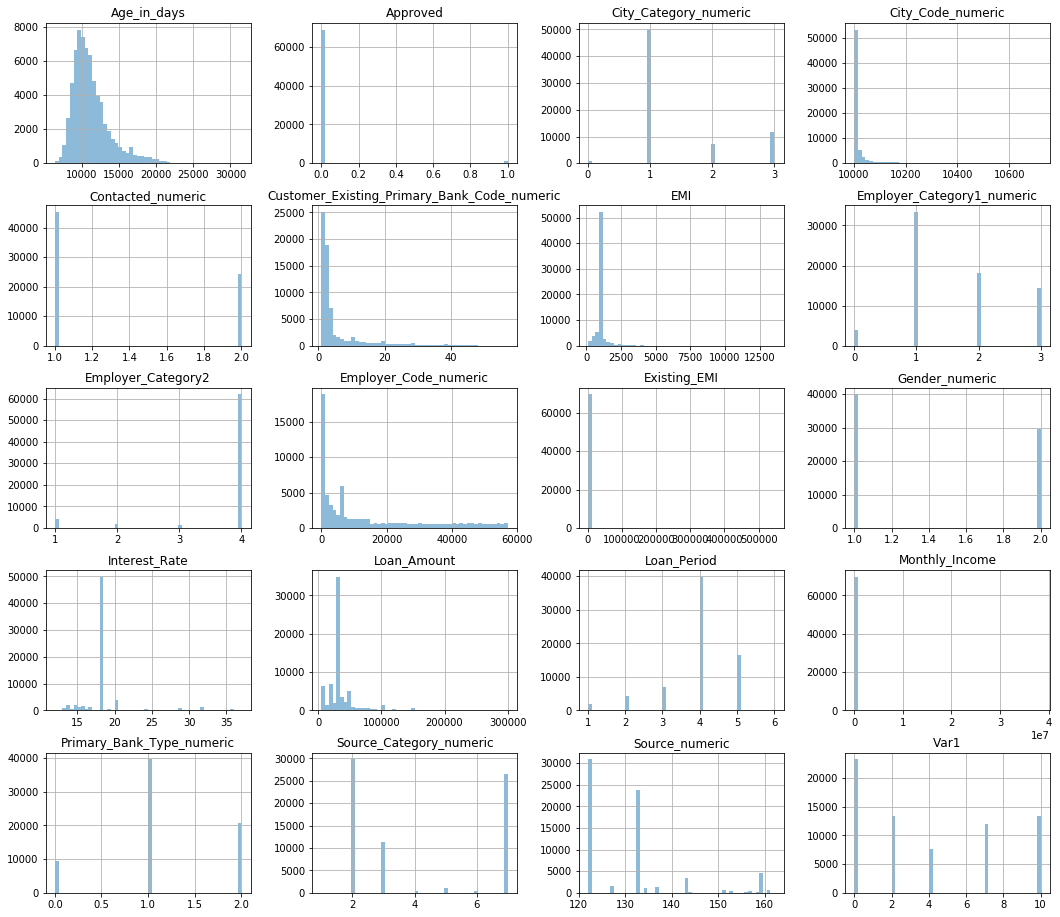

In [23]:
traindf.hist(figsize=(18, 16), alpha=0.5, bins=50)
plt.show()

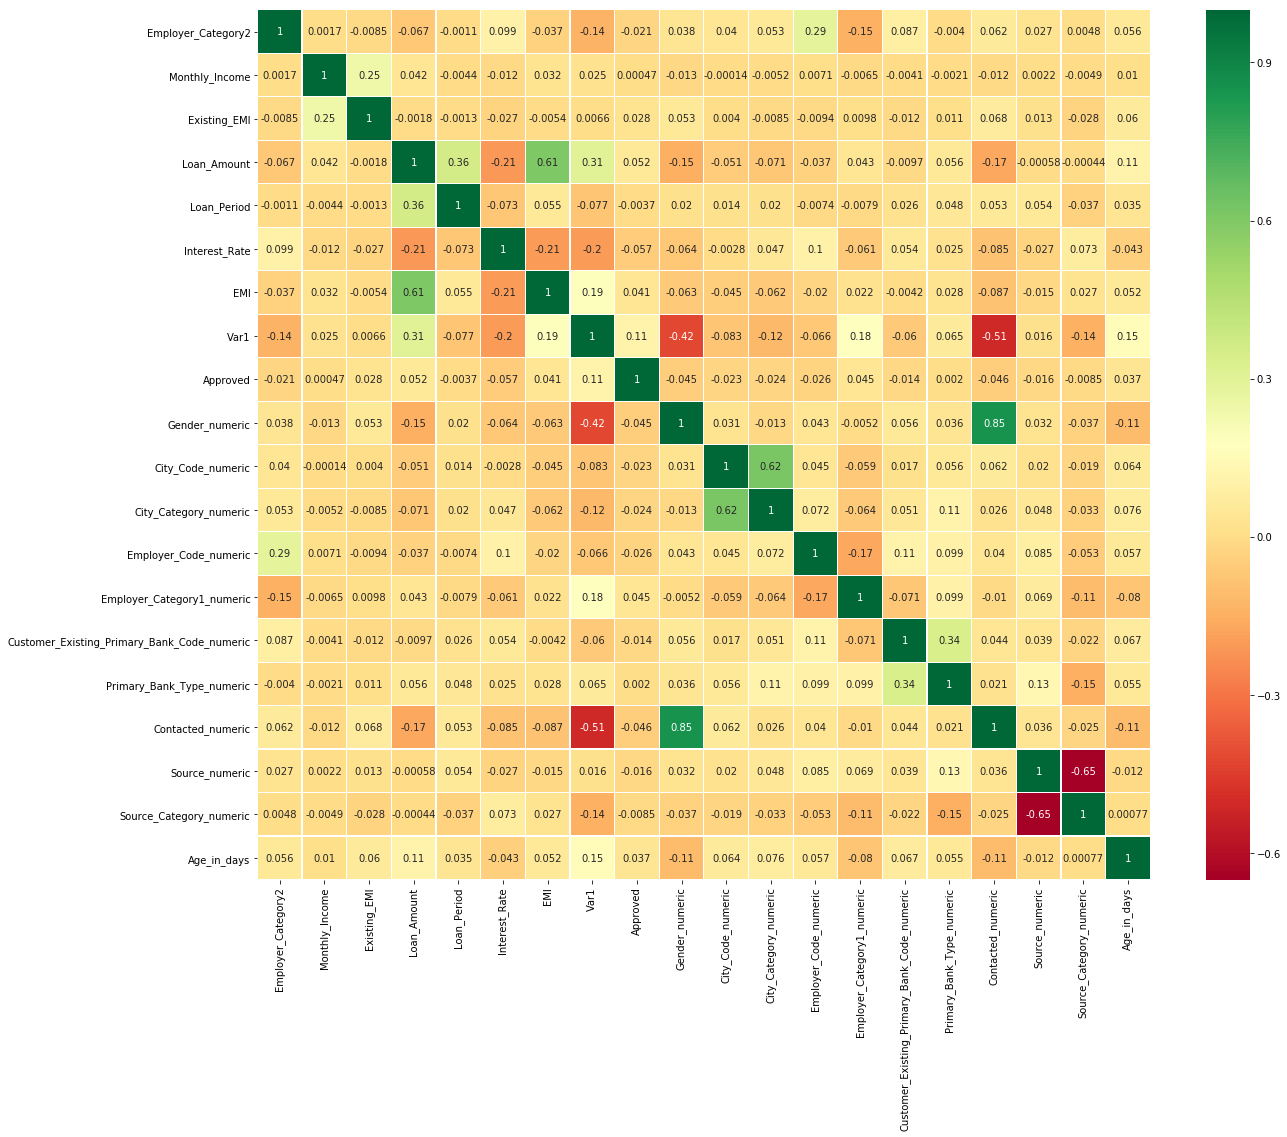

In [24]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show()
fig.savefig('Correlation_before.png')

In [25]:
#drop based on very low positive or negative correlation

traindf = traindf.drop('Monthly_Income', axis=1)
testdf = testdf.drop('Monthly_Income', axis=1)

traindf = traindf.drop('Loan_Period', axis=1)
testdf = testdf.drop('Loan_Period', axis=1)

traindf = traindf.drop('Source_Category_numeric', axis=1)
testdf = testdf.drop('Source_Category_numeric', axis=1)


traindf = traindf.drop('Primary_Bank_Type_numeric', axis=1)
testdf = testdf.drop('Primary_Bank_Type_numeric', axis=1)

#too high correlation with gender and var1 and contacted_numeric - hence removed to avoid duplication of high correlated features
traindf = traindf.drop('Contacted_numeric', axis=1)
testdf = testdf.drop('Contacted_numeric', axis=1)

#traindf = traindf.drop('Var1', axis=1)
#testdf = testdf.drop('Var1', axis=1)


"\ntraindf = traindf.drop('Monthly_Income', axis=1)\ntestdf = testdf.drop('Monthly_Income', axis=1)\n\ntraindf = traindf.drop('Loan_Period', axis=1)\ntestdf = testdf.drop('Loan_Period', axis=1)\n\ntraindf = traindf.drop('Source_Category_numeric', axis=1)\ntestdf = testdf.drop('Source_Category_numeric', axis=1)\n\n\ntraindf = traindf.drop('Primary_Bank_Type_numeric', axis=1)\ntestdf = testdf.drop('Primary_Bank_Type_numeric', axis=1)\n\n#too high correlation with gender and var1 and contacted_numeric - hence removed to avoid duplication of high correlated features\ntraindf = traindf.drop('Contacted_numeric', axis=1)\ntestdf = testdf.drop('Contacted_numeric', axis=1)\n\n#traindf = traindf.drop('Var1', axis=1)\n#testdf = testdf.drop('Var1', axis=1)\n"

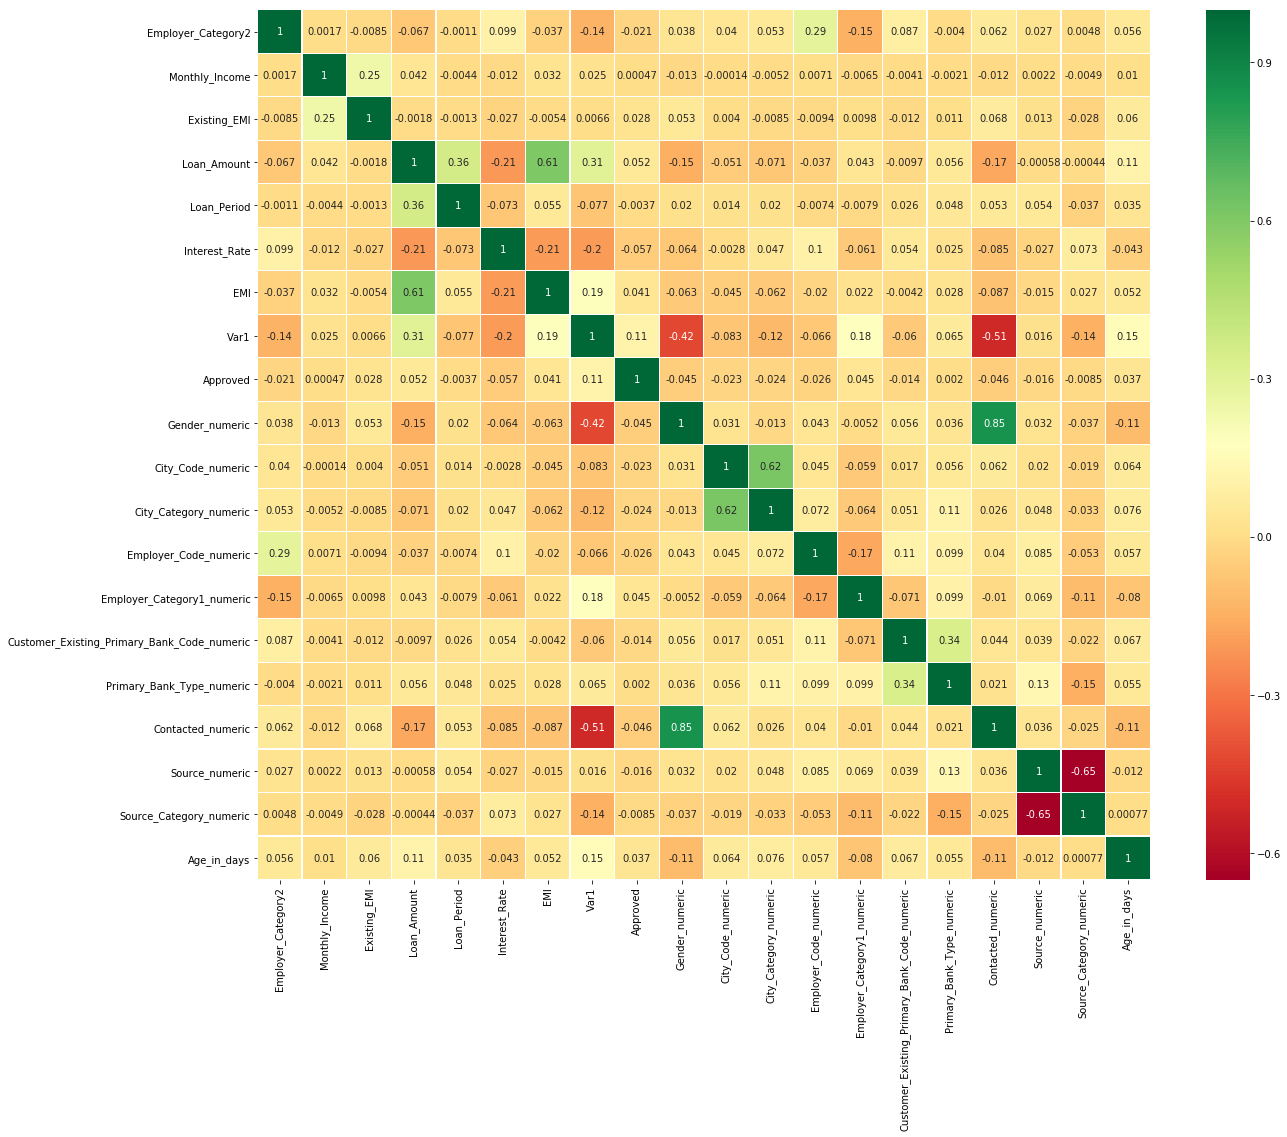

In [26]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show()
fig.savefig('Correlation_after.png')

In [27]:
# extract features from training set - all columns except 'Approved'
train_features = traindf.loc[:, traindf.columns != 'Approved']
print(train_features.columns)


Index(['Employer_Category2', 'Monthly_Income', 'Existing_EMI', 'Loan_Amount',
       'Loan_Period', 'Interest_Rate', 'EMI', 'Var1', 'Gender_numeric',
       'City_Code_numeric', 'City_Category_numeric', 'Employer_Code_numeric',
       'Employer_Category1_numeric',
       'Customer_Existing_Primary_Bank_Code_numeric',
       'Primary_Bank_Type_numeric', 'Contacted_numeric', 'Source_numeric',
       'Source_Category_numeric', 'Age_in_days'],
      dtype='object')


In [28]:
# extract label from training set - Approved
train_label = traindf.loc[:, traindf.columns == 'Approved']
train_label.columns

Index(['Approved'], dtype='object')

In [29]:
# check for null valued columns
print(traindf.columns[traindf.isnull().any()].tolist())
#check test columns
print(testdf.columns)

[]
Index(['Employer_Category2', 'Monthly_Income', 'Existing_EMI', 'Loan_Amount',
       'Loan_Period', 'Interest_Rate', 'EMI', 'Var1', 'Gender_numeric',
       'City_Code_numeric', 'City_Category_numeric', 'Employer_Code_numeric',
       'Employer_Category1_numeric',
       'Customer_Existing_Primary_Bank_Code_numeric',
       'Primary_Bank_Type_numeric', 'Contacted_numeric', 'Source_numeric',
       'Source_Category_numeric', 'Age_in_days'],
      dtype='object')


In [30]:
#for cols in train_features.columns.tolist()[1:]:
#    print(train_features.ix[train_features[cols] < 0])

In [31]:

'''from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
train_features_fs = fs.fit_transform(train_features, train_label)
print('Scores of these features:', fs.scores_)
print(train_features_fs)
print(np.ravel(train_features_fs))
'''


"from sklearn import feature_selection\nfs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)\ntrain_features_fs = fs.fit_transform(train_features, train_label)\nprint('Scores of these features:', fs.scores_)\nprint(train_features_fs)\nprint(np.ravel(train_features_fs))\n"

In [32]:
'''
# define the parameter values that should be searched
hidden_layer_sizes= [(7, 7),(5, 2), (128, 7)]
tol= [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
epsilon= [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
alpha= [1e-5, 1e-7, 1e-8, 1e-9, 1e-8]
solver= ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']

from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
# specify "parameter distributions" rather than a "parameter grid"
#MLPClassifier(learning_rate='adaptive', learning_rate_init=1., early_stopping=True, shuffle=True),
#param_grid=param_grid, n_jobs=-1)
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
param_dict = dict(hidden_layer_sizes=hidden_layer_sizes,tol=tol,epsilon=epsilon,alpha=alpha,solver=solver,learning_rate=learning_rate)

conv_X = pd.get_dummies(train_features.iloc[:, :]) 
conv_Y = pd.get_dummies(train_label['Approved']) 
#print(conv_Y)
#print(conv_X)

# n_iter controls the number of searches
#rand = GridSearchCV(model, param_dict, cv=10, scoring='roc_auc',  n_jobs=-1)
rand = RandomizedSearchCV(model, param_dict, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(conv_X, conv_Y)
print("GRID SCORES >>> ",rand.grid_scores_)

# examine the best model
print("BEST SCORE >>> ",rand.best_score_)
print("BEST PARAMETERS >>> ",rand.best_params_)
print("BEST ESTIMATORS >>> ",rand.best_estimator_)
'''
#BEST SCORE >>>  0.9853685826173023
#BEST PARAMETERS >>>  {'tol': 0.01, 'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5, 2), 'epsilon': 1e-07, 'alpha': 1e-08}

'\n# define the parameter values that should be searched\nhidden_layer_sizes= [(7, 7),(5, 2), (128, 7)]\ntol= [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]\nepsilon= [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]\nalpha= [1e-5, 1e-7, 1e-8, 1e-9, 1e-8]\nsolver= [\'lbfgs\', \'sgd\', \'adam\']\nlearning_rate = [\'constant\', \'invscaling\', \'adaptive\']\n\nfrom sklearn.grid_search import RandomizedSearchCV\nfrom sklearn.grid_search import GridSearchCV\n# specify "parameter distributions" rather than a "parameter grid"\n#MLPClassifier(learning_rate=\'adaptive\', learning_rate_init=1., early_stopping=True, shuffle=True),\n#param_grid=param_grid, n_jobs=-1)\nmodel = MLPClassifier(solver=\'lbfgs\', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)\nparam_dict = dict(hidden_layer_sizes=hidden_layer_sizes,tol=tol,epsilon=epsilon,alpha=alpha,solver=solver,learning_rate=learning_rate)\n\nconv_X = pd.get_dummies(train_features.iloc[:, :]) \nconv_Y = pd.get_dummies(train_label[\'Approved\']) \n#print(conv_Y)\n#print(conv_X

In [33]:
#Train the model with best parameters of RF
# best params for RF using randomizedCV
# {StandardScaler(with_std=True), PCA(n_components=10), RandomForestClassifier(max_depth=5, n_estimators=85, min_samples_split=2) #best 0.783
#MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
model = make_pipeline(StandardScaler(with_std=True), PCA(n_components=10), MLPClassifier(activation='relu', solver='lbfgs', alpha=1e-9, hidden_layer_sizes=(5, 2), random_state=1))
'''model = make_pipeline(StandardScaler(with_std=True), PCA(n_components=10), MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=0.001,
       hidden_layer_sizes=(5, 2), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.01, validation_fraction=0.1, verbose=False,
       warm_start=False))'''


model.fit(train_features, train_label)
train_pred = model.predict(train_features)
print(metrics.accuracy_score(train_label, train_pred)) # Training Accuracy Score
print (np.sqrt(mean_squared_error(train_label, train_pred))) # Training RMSE
print(roc_auc_score(train_label, train_pred)) # AUC-ROC values

C:\ProgramData\Anaconda3-5.0.1\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.985368582617
0.120960395927
0.5


In [34]:
#Predict with test data - predict probabilities
test_pred = model.predict_proba(testdf) #test features are all in testdf

print(test_pred) # Predicted Values
#print(np.unique(test_pred)) # unique values

[[  9.96708387e-01   3.29161309e-03]
 [  9.67490552e-01   3.25094480e-02]
 [  9.99182171e-01   8.17828974e-04]
 ..., 
 [  9.97563468e-01   2.43653215e-03]
 [  9.83849380e-01   1.61506199e-02]
 [  9.97212149e-01   2.78785123e-03]]


In [35]:
#Prepare outputdf to populate CSV
#output df
#print(test_pred.classes_)
#print(testdf.index)
#print(test_pred[:,1])
outputdf = pd.DataFrame()
outputdf['ID'] = testdf.index
outputdf['Approved'] = test_pred[:,1]

In [36]:
#outputdf

In [37]:
#Save to CSV file in submission format
outputdf.to_csv("output_mlp.csv", sep=",", index=False)